## Alternative prevalence filtering

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import time

In [2]:
# Change working directory
os.chdir('/media/HDD_4TB_1/jordi/cfuses_gnn_enrollhd_2024/')

# Input and output directories
data_dir = "data/features/"

In [4]:
# Read the first line of the txt file to get column names
with open(data_dir + "X_pc10.txt") as f:
    first_line = f.readline().strip()
column_names = first_line.split("\t")[1:]

# Create a dictionary to specify data types for all columns except the first one
dtype_dict = {col: 'uint8' for col in column_names}

In [7]:
# Read the CSV file with specified data types
X = pd.read_csv(data_dir + "X_pc10.txt", sep = "\t", dtype=dtype_dict, engine='c')

In [18]:
# Set sample identification as index
X.set_index('FID_IID', inplace=True)

In [19]:
# Get rid of sex and CAG columns
X.drop('Sex', axis = 1, inplace=True)
X.drop('CAG', axis = 1, inplace=True)

Alternative prevalence minimum of x% = at least the x% of samples have the alternative allele in one or both chromosomes of that SNP, or equivalently, don't have a 0 expression in that SNP, as 0 means being homozygous for the reference allele. 

We will take different minimum prevalence values and see how the size of the SNPs group that pass each increasing thresholds is reduced.   

In [8]:
# Names of snps in matrix (column names)
# in the whole feature matrix we already have them stored in features/subsetting/refIDs_row.txt

colnames = X.columns

In [9]:
# remove duplicate columns. This problem has to be resolved from root, this is just temporary
# due to repetitions in VCF file!!
duplicate_col_names = [snp for snp in colnames if '.' in snp]

In [10]:
for snp in duplicate_col_names:
    X.drop(snp, axis = 1, inplace=True)

In [11]:
colnames = X.columns

In [12]:
# Total number of samples
n_samples = len(X)

In [13]:
# Initialize vector to store prevalence of alternative variant, always taking first two
rowsums = []

# Sum all rows of each column
for col in colnames:
    col_sum = sum([1 for val in X[col] if val != 0])
    rowsums.append(col_sum)

In [14]:
def min_prevalence_filtering(min_prevalence,rowsums,snpnames,n_samples):    
        
    # Variable to count how many SNPs pass the threshold 
    n_approved_snps = 0

    # List to save approved snp names
    approved_snps = []

    # Check each SNP sum across samples
    for idx,samplesum in enumerate(rowsums):
        if samplesum >= min_prevalence*n_samples:
            
            # Increase counter
            n_approved_snps +=1
            
            # Add snp name
            approved_snps.append(snpnames[idx])
            
    return n_approved_snps, approved_snps
    #return n_approved_snps

In [15]:
# Values of minimum prevalence to test
minvals = np.arange(0,1.1,0.1)
minvals = np.array([round(x,1) for x in minvals])

In [16]:
# SNPs filtered in each val
snps_filtered_per_val = {}

# Save n_approved_snps for each minimum prevalence value
dependant_n_approved_snps = []
for val in minvals:
    n_approved_snps, approved_snps = min_prevalence_filtering(val,rowsums,colnames,n_samples)
    dependant_n_approved_snps.append(n_approved_snps)
    snps_filtered_per_val[val] = approved_snps
    
# Create dataframe with results for display
prevalence_filtering_sizes = pd.DataFrame({'Minimum alternative prevalence':minvals*100, 'Number of SNPs':dependant_n_approved_snps})

In [11]:
# Pickle dataframe
with open(data_dir + 'subsetting/' + 'prevalence_filtering_sizes.pkl', 'wb') as f:
    pickle.dump(prevalence_filtering_sizes, f)

# Pickle dictionary
with open(data_dir + 'subsetting/' + 'snps_filtered_per_val.pkl', 'wb') as f:
    pickle.dump(snps_filtered_per_val, f)

<Axes: xlabel='Minimum alternative prevalence', ylabel='Number of SNPs'>

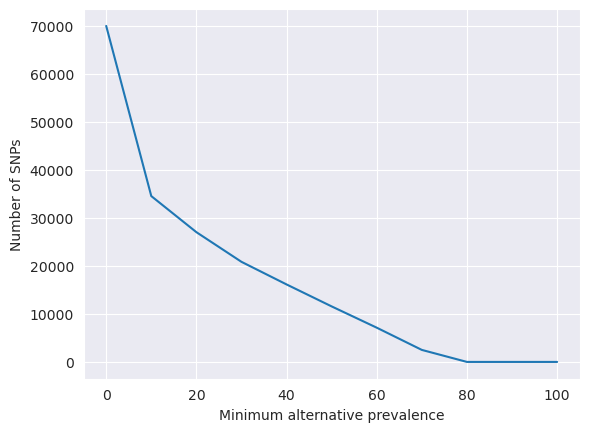

In [10]:
# Plot result
sns.set_style("darkgrid")
sns.lineplot(data=prevalence_filtering_sizes, x="Minimum alternative prevalence", y="Number of SNPs")

In [ ]:
# to read pickles back

# Load the DataFrame prevalence_filtering
#with open(data_dir+'prevalence_filtering_sizes.pkl', 'rb') as f:
#    prevalence_filtering = pickle.load(f)

# Load the dictionary snps_filtered_per_val
#with open(data_dir+'snps_filtered_per_val.pkl', 'rb') as f:
#    snps_filtered_per_val = pickle.load(f)

### Grouping by genes

In [17]:
# Read filtered lookup table
snp_gene_GO = pd.read_csv("data/SNPs/snps_gene_GO_m3.txt", sep = "\t")

In [16]:
snp_gene_GO

,SNP,Gene,GO_term
0,rs4705963,KIF3A,GO:0098930
1,rs12514976,KIF3A,GO:0098930
2,rs17166194,KIF3A,GO:0098930
3,rs138078401,KIF3A,GO:0098930
4,rs143317845,KIF3A,GO:0098930
...,...,...,...
69995,rs187594980,SOSTDC1,extra_genes
69996,rs142640995,SOSTDC1,extra_genes
69997,rs17367241,SOSTDC1,extra_genes
69998,rs11766241,SOSTDC1,extra_genes


In [18]:
# Dictionary to save what genes surpass each minimum value, values as keys
genes_approved_per_val = {}

for minval in minvals:
    
    # Genes with SNPs included
    genes_approved = []

    # Aggrupate 
    for snp in snps_filtered_per_val[minval]:
        gene = snp_gene_GO[snp_gene_GO['SNP']==snp]['Gene'].iloc[0]
        if gene in genes_approved:
            continue
        else:
            genes_approved.append(gene)
    
    # Save in dictionary
    genes_approved_per_val[minval] = genes_approved     


In [ ]:
# get number of included genes for each minimum prevalence value

# Save n_approved_snps for each minimum prevalence value
dependant_n_approved_genes = []

for minval in minvals:
    dependant_n_approved_genes.append(len(genes_approved_per_val[minval]))

In [ ]:
# Create dataframe with results for display
prevalence_filtering_sizes_genes = pd.DataFrame({'Minimum alternative prevalence':minvals*100, 'Number of genes':dependant_n_approved_genes})

<Axes: xlabel='Minimum alternative prevalence', ylabel='Number of genes'>

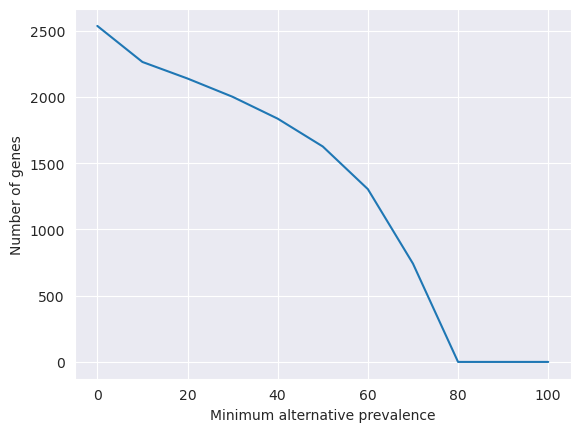

In [ ]:
# Plot result
sns.set_style("darkgrid")
sns.lineplot(data=prevalence_filtering_sizes_genes, x="Minimum alternative prevalence", y="Number of genes")

### Considering GO terms 

In [22]:
# Initialize a dictionary to store the count of genes for each minimum prevalence value and GO term
go_gene_counts_by_prevalence = {go_term: {prevalence: 0 for prevalence in genes_approved_per_val.keys()} for go_term in snp_gene_GO['GO_term'].unique()}

# Fill the dictionary with the count of genes for each minimum prevalence value and GO term
for prevalence, genes_list in genes_approved_per_val.items():
    for gene in genes_list:
        go_terms_for_gene = snp_gene_GO[snp_gene_GO['Gene'] == gene]['GO_term'].unique()
        for go_term in go_terms_for_gene:
            go_gene_counts_by_prevalence[go_term][prevalence] += 1


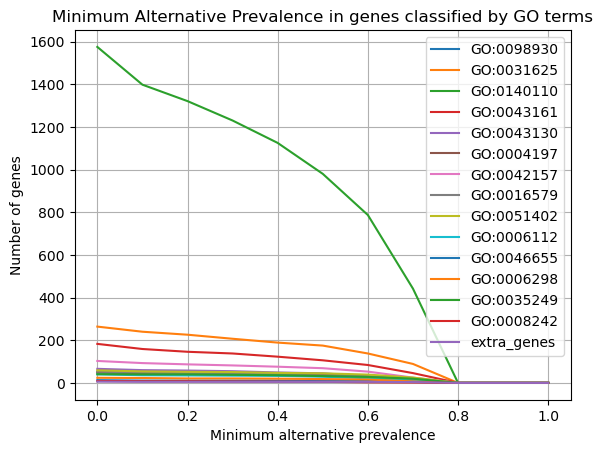

In [24]:
plt.figure()

for go_term, prevalence_counts in go_gene_counts_by_prevalence.items():
    prevalences = list(prevalence_counts.keys())
    gene_counts = list(prevalence_counts.values())
    plt.plot(prevalences, gene_counts, label=go_term)

plt.xlabel('Minimum alternative prevalence')
plt.ylabel('Number of genes')
plt.title('Minimum alternative prevalence in genes classified by GO terms')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Relative number of genes to its initial GO size
go_gene_counts_by_prevalence_relative = {go_term: {prevalence: 0 for prevalence in genes_approved_per_val.keys()} for go_term in snp_gene_GO['GO_term'].unique()}

for go_term in go_gene_counts_by_prevalence.keys():
    for min in go_gene_counts_by_prevalence[go_term]:
        if min != 0.0:
            go_gene_counts_by_prevalence_relative[go_term][min] = go_gene_counts_by_prevalence[go_term][min]/total_counter
        else:
            total_counter = go_gene_counts_by_prevalence[go_term][min]
            go_gene_counts_by_prevalence_relative[go_term][min] = 1

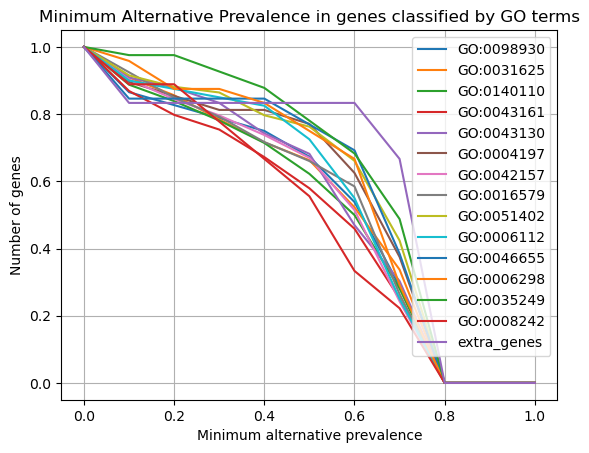

In [28]:
plt.figure()

for go_term, prevalence_counts in go_gene_counts_by_prevalence_relative.items():
    prevalences = list(prevalence_counts.keys())
    gene_counts = list(prevalence_counts.values())
    plt.plot(prevalences, gene_counts, label=go_term)

plt.xlabel('Minimum alternative prevalence')
plt.ylabel('Number of genes')
plt.title('Relative inimum alternative prevalence in genes')
plt.legend()
plt.grid(True)
plt.show()